#📌 Extracción

In [9]:
# Librarys used here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tabulate as tabulate
import folium
from pandas import json_normalize
from folium.plugins import HeatMap
import warnings
import dfply as dp

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import json

#### Diccionario de datos

- `customerID`: número de identificación único de cada cliente
- `Churn`: si el cliente dejó o no la empresa
- `gender`: género (masculino y femenino)
- `SeniorCitizen`: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- `Partner`: si el cliente tiene o no una pareja
- `Dependents`: si el cliente tiene o no dependientes
- `tenure`: meses de contrato del cliente
- `PhoneService`: suscripción al servicio telefónico
- `MultipleLines`: suscripción a más de una línea telefónica
- `InternetService`: suscripción a un proveedor de internet
- `OnlineSecurity`: suscripción adicional de seguridad en línea
- `OnlineBackup`: suscripción adicional de respaldo en línea
- `DeviceProtection`: suscripción adicional de protección del dispositivo
- `TechSupport`: suscripción adicional de soporte técnico, menor tiempo de espera
- `StreamingTV`: suscripción de televisión por cable
- `StreamingMovies`: suscripción de streaming de películas
- `Contract`: tipo de contrato
- `PaperlessBilling`: si el cliente prefiere recibir la factura en línea
- `PaymentMethod`: forma de pago
- `Charges.Monthly`: total de todos los servicios del cliente por mes
- `Charges.Total`: total gastado por el cliente

In [4]:
df1.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [ ]:
with open("TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df1= json_normalize(data) 
df1= pd.DataFrame(df1)
df1.info()





56.05


In [26]:
# create a summary DataFrame with the required statistics
# including the number of nulls, unique values, max, min, mean, and standard
df1.replace(["" , " "], np.nan, inplace=True)

summary = pd.DataFrame({
    'Columna': df1.columns,
    'Tipo de Dato': df1.dtypes.values,
    'Nulos': df1.isnull().sum().values,
    'Únicos': df1.nunique().values
})


summary = summary.sort_values(by='Nulos', ascending=False).reset_index(drop=True)


print(summary.to_markdown(index=False))

| Columna                   | Tipo de Dato   |   Nulos |   Únicos |
|:--------------------------|:---------------|--------:|---------:|
| Churn                     | object         |     224 |        2 |
| account.Charges.Total     | object         |      11 |     6530 |
| customerID                | object         |       0 |     7267 |
| customer.SeniorCitizen    | int64          |       0 |        2 |
| customer.gender           | object         |       0 |        2 |
| customer.Partner          | object         |       0 |        2 |
| customer.Dependents       | object         |       0 |        2 |
| phone.PhoneService        | object         |       0 |        2 |
| customer.tenure           | int64          |       0 |       73 |
| internet.InternetService  | object         |       0 |        3 |
| internet.OnlineSecurity   | object         |       0 |        3 |
| internet.OnlineBackup     | object         |       0 |        3 |
| phone.MultipleLines       | object         |  

Antes de iniciar el análisis de evasión de clientes, es fundamental aplicar una serie de transformaciones al dataset para garantizar su calidad. Primero, es necesario aplanar la estructura anidada del JSON utilizando `pd.json_normalize()`, lo que facilita el acceso a las variables. Luego, se deben reemplazar cadenas vacías `""` por valores nulos (`NaN`) para su correcta identificación y manejo. Es crucial convertir columnas numéricas que vienen como texto, como `account.Charges.Total`, a tipo `float`, y transformar columnas categóricas (`gender`, `Partner`, etc.) al tipo `category`, optimizando así el uso de memoria. También se recomienda unificar formatos y corregir inconsistencias como valores mal escritos o no estándar. La variable objetivo `Churn` debe convertirse a binaria (`Yes` = 1, `No` = 0) para facilitar su análisis. Se deben revisar y tratar los valores nulos, ya sea imputándolos o eliminándolos según el caso. Además, es importante eliminar duplicados y verificar la consistencia lógica entre variables relacionadas (por ejemplo, si `PhoneService` es "No", entonces `MultipleLines` no debe estar activo). Estas transformaciones aseguran un dataset limpio, estructurado y listo para generar insights confiables.


#🔧 Transformación

In [30]:

# trasform the DataFrame to have a more readable format

cat_cols = [ 'customer.gender','internet.InternetService','account.Contract','account.PaymentMethod',
            'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']
for col in cat_cols:
    df1[col] = df1[col].astype('category')


# convert the 'customer.SeniorCitizen' column to boolean

cat_cols = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
    'account.PaperlessBilling', 'Churn','customer.SeniorCitizen']

# remplace Yes/No with 1/0

df1 = df1.replace({'Yes': 1, 'No': 0})

for col in cat_cols:
    df1[col] = df1[col].astype('bool')
    

# convert the 'account.Charges.Total' column to float
df1['account.Charges.Total'] = df1['account.Charges.Total'].astype(float)

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7267 non-null   object  
 1   Churn                      7267 non-null   bool    
 2   customer.gender            7267 non-null   category
 3   customer.SeniorCitizen     7267 non-null   bool    
 4   customer.Partner           7267 non-null   bool    
 5   customer.Dependents        7267 non-null   bool    
 6   customer.tenure            7267 non-null   int64   
 7   phone.PhoneService         7267 non-null   bool    
 8   phone.MultipleLines        7267 non-null   bool    
 9   internet.InternetService   7267 non-null   category
 10  internet.OnlineSecurity    7267 non-null   category
 11  internet.OnlineBackup      7267 non-null   category
 12  internet.DeviceProtection  7267 non-null   category
 13  internet.TechSupport       7267 n

#📊 Carga y análisis

In [32]:
# load data base in .CSV format
df1.to_csv("TelecomX_Data_Cleaned.csv", index=False)


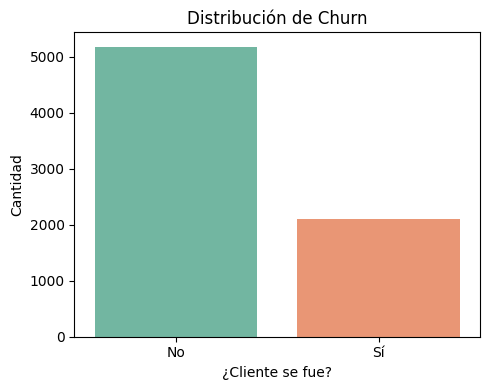

In [33]:
# 1. Distribución de Churn
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df1, palette='Set2')
plt.title("Distribución de Churn")
plt.xlabel("¿Cliente se fue?")
plt.ylabel("Cantidad")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

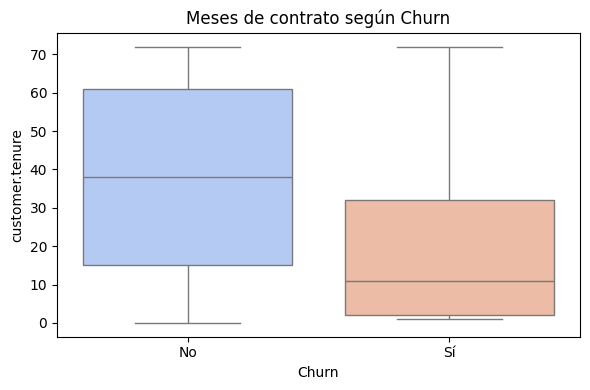

In [34]:
# 2. Tenure promedio según churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='customer.tenure', data=df1, palette='coolwarm')
plt.title("Meses de contrato según Churn")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

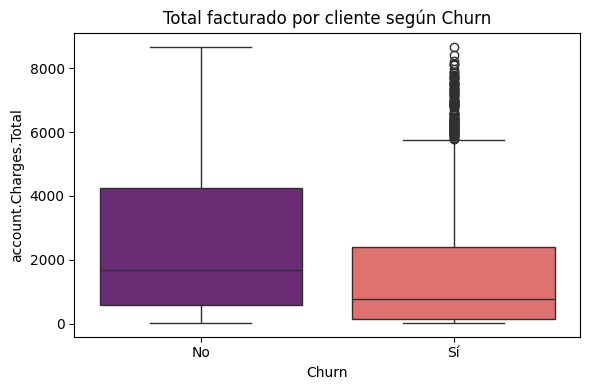

In [36]:
# 4. Total acumulado vs churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df1, palette='magma')
plt.title("Total facturado por cliente según Churn")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

#📄Informe final

array(['Yes', 'No', 'No internet service'], dtype=object)